The purpose of this notebook is to record a recipe on how to make three versions of TRILEGAL HiPSCat catalog: with fixed NSIDE=[32,64] (variable number of sources per pix) and with variable pixel sizes (roughly the same number of sources in each pixel). 

Note that **magnitudes with extinction** and **colors with extinction removed** are returned.

TRILEGAL files were downloaded from DataLab.

The output catalogs will have column names changed to comply with photoD, and `Mr` computed from `rmag`, `Ar` and `DM`.

Remember to copy `dtypes_TRILEGAL.txt`.

In [1]:
import glob
import multiprocessing as mp
import numpy as np
import pandas as pd
import os
from tqdm import tqdm


pd.set_option('display.max_columns', None)

### 1) Find all single-star TRILEGAL CSVs, convert them to parquet

In [2]:
files = glob.glob("/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_DataLab/data/single/chunk_*/*")
print(len(files))

511890


Define which TRILEGAL columns (and their dtypes) will be imported. ```dtypes.txt_TRILEGAL``` file was generated from the data type descriptions on [DataLab](https://datalab.noirlab.edu/query.php?name=lsst_sim.simdr2). 

In [3]:
_ = pd.read_csv(files[0]) # .head(2)
_.rename(columns={"av": "Av"}, inplace=True)
_

,ra,dec,gall,galb,elon,elat,m_ini,logage,m_h,mu0,Av,mratio,mass,logl,logte,logg,mcoretp,c_o,period0,period1,period2,period3,period4,mloss,tau1m,x,y,xc,xn,xo,cexcess,z,mbolmag,umag,gmag,rmag,imag,zmag,ymag,gaia_gmag,g_bpmag,g_rpmag,velu,velv,velw,vrad,pmracosd,pmdec,random_id,htm9,ring256,nest4096,gc,label,pmode
0,300.028833,-7.907565,33.590902,-18.841776,300.499707,12.408929,0.15301,10.07,-0.49,13.55,0.390,0,0.153,-2.569,3.4956,5.125,0.0,0.545,0,0,0,0,0,0,0,0.7317,0.2633,0.000899,0.000242,0.002199,-1.0,0.004999,24.743,31.832,28.458,26.849,25.339,24.617,24.292,26.021,27.784,24.803,112.19,-2.24,-30.53,-87.92,3.69,1.01,24.539366,2932081,446805,122111240,2,1,-1
1,300.031539,-7.907524,33.592184,-18.844168,300.502403,12.408422,0.22518,9.91,-0.31,13.85,0.556,0,0.224,-2.246,3.5099,5.025,0.0,0.545,0,0,0,0,0,0,0,0.7253,0.2672,0.001344,0.000362,0.003287,-1.0,0.007470,24.235,30.851,27.656,26.126,24.772,24.113,23.803,25.436,27.036,24.261,123.81,-13.19,-1.95,-112.06,2.47,1.14,0.512515,2932081,446805,122111240,1,1,-1
2,300.019627,-7.899453,33.594373,-18.830023,300.492259,12.418729,0.35393,10.11,-1.68,18.00,0.477,0,0.354,-1.526,3.6265,4.971,0.0,0.544,0,0,0,0,0,0,0,0.7390,0.2607,0.000064,0.000017,0.000157,-1.0,0.000357,26.585,30.600,28.353,27.218,26.709,26.434,26.282,27.143,27.966,26.295,99.66,-124.02,-51.21,-135.42,0.40,-0.47,81.816980,2932081,446805,122111242,3,1,-1
3,300.020413,-7.899483,33.594705,-18.830735,300.493033,12.418541,0.19714,10.05,-0.37,14.65,0.447,0,0.196,-2.349,3.5062,5.056,0.0,0.545,0,0,0,0,0,0,0,0.7267,0.2668,0.001171,0.000316,0.002864,-1.0,0.006510,25.292,32.018,28.779,27.228,25.839,25.166,24.853,26.508,28.145,25.323,115.40,-185.77,-10.96,-193.27,0.92,-2.91,70.406280,2932081,446805,122111242,2,1,-1
4,300.019985,-7.897315,33.596567,-18.829402,300.493061,12.420750,0.39647,10.07,-1.22,16.45,0.455,0,0.396,-1.496,3.6059,4.907,0.0,0.545,0,0,0,0,0,0,0,0.7489,0.2501,0.000171,0.000046,0.000418,-1.0,0.000950,24.959,29.486,26.984,25.693,25.113,24.803,24.632,25.592,26.511,24.692,12.28,-146.06,-104.46,-61.05,0.81,-1.76,57.823353,2932081,446805,122111242,3,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,300.130267,-7.695318,33.839012,-18.838750,300.644870,12.596181,0.28711,10.11,-1.24,14.25,0.514,0,0.286,-1.797,3.5875,4.993,0.0,0.545,0,0,0,0,0,0,0,0.7380,0.2611,0.000165,0.000044,0.000403,-1.0,0.000917,23.512,28.413,25.742,24.338,23.691,23.348,23.161,24.204,25.202,23.264,-18.15,-144.45,-69.73,-47.47,0.92,-4.73,93.114200,2932080,446805,122111447,3,1,-1
13636,300.130932,-7.694759,33.839849,-18.839097,300.645648,12.596593,0.39890,10.07,-1.38,17.65,0.341,0,0.399,-1.460,3.6166,4.917,0.0,0.545,0,0,0,0,0,0,0,0.7496,0.2497,0.000123,0.000033,0.000301,-1.0,0.000684,26.069,30.356,27.967,26.751,26.208,25.916,25.755,26.665,27.537,25.791,80.71,-54.10,95.25,-131.03,-0.27,0.14,34.866608,2932080,446805,122111447,3,1,-1
13637,300.117823,-7.684677,33.843373,-18.822994,300.634731,12.609119,0.20973,10.07,-0.64,12.75,0.486,0,0.209,-2.218,3.5317,5.055,0.0,0.545,0,0,0,0,0,0,0,0.7327,0.2637,0.000657,0.000177,0.001608,-1.0,0.003654,23.066,29.171,26.080,24.511,23.437,22.889,22.637,24.063,25.426,22.966,-7.40,-124.09,-15.66,-62.69,-0.34,-6.85,27.193700,2932080,446805,122111453,2,1,-1
13638,300.117142,-7.684109,33.843598,-18.822138,300.634173,12.609814,0.78513,9.71,0.02,10.00,0.457,0,0.785,-0.541,3.6941,4.603,0.0,0.537,0,0,0,0,0,0,0,0.7287,0.2567,0.002584,0.000706,0.006416,-1.0,0.014590,16.123,19.746,17.396,16.476,16.154,15.993,15.897,16.480,17.121,15.762,45.86,-30.33,7.57,-62.80,4.11,-1.67,42.960743,2932080,446805,122111453,1,1,-1


In [4]:
columns=['ra', 'dec', 'gall', 'galb' , 'm_ini', 'logage', 'm_h', 'mu0', 'av', 'mratio', 'mass', 'logl', 
         'logte', 'logg', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'gc', 'label', 'ring256']

types = []
trilegal_dtypes = np.loadtxt("dtypes_TRILEGAL.txt", delimiter=",", dtype=str)
for i in trilegal_dtypes[:, 1]:
    if i=='REAL':
        types.append(np.float32)
    elif i=='DOUBLE':
        types.append(np.float64)
    elif i=='SMALLINT':
        types.append(np.int16)
    elif i=='INTEGER':
        types.append(np.int32)
schema = list(zip(trilegal_dtypes[:,0].tolist(), types))

In [5]:
filesizes = list(tqdm(map(os.path.getsize, files), total=len(files)))

100%|███████████████████████████████████████████| 511890/511890 [00:51<00:00, 9881.32it/s]


In [6]:
thresh = 6 * 1024 # in megabytes
npfiles = np.array(files)
fs = np.array(filesizes) / 1024 / 1024 # in megabytes
x = (np.cumsum(fs) // thresh).astype(int)
u = np.unique(x)
groups = dict()
for fileId in u:
    groups[f"/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_parquet/TRILEGAL-{fileId:06d}.parquet"] = npfiles[x == fileId]

Roughly balance the size of parquet files, change the column names, add Mr column, correct colors for extinction effects and write out ~697 parquets.

Extinction correction is needed because TRILEGAL colors *are* extincted; we want the unextincted colors.

In [7]:
def extcoeff():
        ## coefficients to correct for ISM dust (for S82 from Berry+2012, Table 1)
        ## extcoeff(band) = A_band / A_r 
        extcoeff = {}
        extcoeff['u'] = 1.810
        extcoeff['g'] = 1.400
        extcoeff['r'] = 1.000  # by definition
        extcoeff['i'] = 0.759 
        extcoeff['z'] = 0.561 
        return extcoeff 

def compactify(out, inputs):
    dfs = [ pd.read_csv(fn, usecols=columns, dtype=dict(schema)) for fn in inputs ]
    for i, d in enumerate(dfs):
        d=d.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", "m_h": "FeH", "av": "Av", "mu0": "DM"})
        d.loc[:, 'Ar'] = 2.75 * d.loc[:, 'Av'] / 3.10  
        d['Mr'] = d['rmag'] - d['Ar'] - d['DM']
        C = extcoeff()
        d['ug'] = d['umag'] - d['gmag'] - (C['u'] - C['g'])*d['Ar']  
        d['gr'] = d['gmag'] - d['rmag'] - (C['g'] - C['r'])*d['Ar']   
        d['ri'] = d['rmag'] - d['imag'] - (C['r'] - C['i'])*d['Ar']   
        d['iz'] = d['imag'] - d['zmag'] - (C['i'] - C['z'])*d['Ar']   
        d['gi'] = d['gr'] + d['ri']
        dfs[i] = d
    df = pd.concat(dfs)
    df.to_parquet(out, index=False)
    
def compactify_aux(args):
    return compactify(*args)

In [8]:
with mp.Pool(processes=96) as pool:
    for _ in tqdm(pool.imap_unordered(compactify_aux, groups.items()), total=len(groups)):
        pass

100%|███████████████████████████████████████████████████| 697/697 [11:38<00:00,  1.00s/it]


Quick check: skymap.

100%|███████████████████████████████████████████████████| 697/697 [00:25<00:00, 26.99it/s]


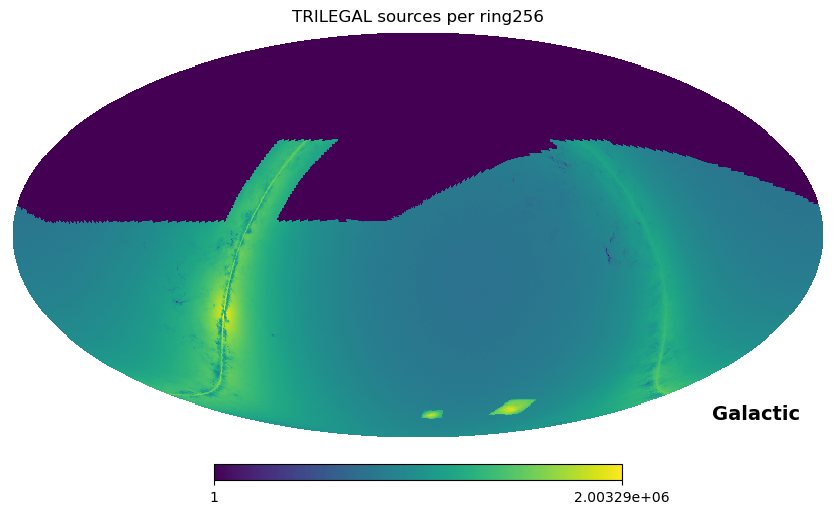

In [11]:
%matplotlib inline
import healpy as hp

NSIDE=2**9

def skymap_aux(fn):
    df = pd.read_parquet(fn, columns='ra dec'.split())
    ipix = hp.ang2pix(NSIDE, df["ra"], df["dec"], nest=True, lonlat=True)
    i, ct = np.unique(ipix, return_counts=True)
    return i, ct

img = np.zeros(hp.nside2npix(NSIDE), dtype=int)
fns = list(glob.glob('/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_parquet/TRILEGAL-*.parquet'))
fsub = fns

with mp.Pool(processes=96) as pool:
    for i, ct in tqdm(pool.imap_unordered(skymap_aux, fsub), total=len(fsub)):
        img[i] += ct

hp.mollview(img+1, title="TRILEGAL sources per ring256", 
            coord='G', flip='geo', norm='log', nest=True)

### 2) Import into a HiPSCat catalog (with variable pixel sizes, roughly constant number of sources per pixel)

In [1]:
import hipscat_import.pipeline as runner
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.catalog.file_readers import ParquetReader

in_file_paths = glob.glob("/mnt/beegfs/scratch/data/TRILEGAL_parquet/TRILEGAL-*.parquet")
print(f"Input files: {len(in_file_paths)}")
in_file_paths.sort()
args = ImportArguments(
    output_artifact_name="TRILEGAL",
    output_path="/mnt/beegfs/scratch/data/TRILEGAL_hipscat/",
    input_file_list=in_file_paths,
    file_reader="parquet",
    ra_column="ra",
    dec_column="dec",
    highest_healpix_order=10,
    catalog_type="object",
    sort_columns="ra",
    dask_n_workers=96,
    dask_tmp="/nvme/tmp/dask_tmp",
    tmp_dir="/nvme/tmp/tmp_dir",
    resume=False,
    pixel_threshold=5_000_000,
    add_hipscat_index=True    
)
runner.pipeline(args)

KeyboardInterrupt: 

Spin up a DASK cluster to speed up plotting.

In [11]:
from dask.distributed import Client

# client = Client(n_workers=96, threads_per_worker=1, memory_limit="auto")
client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39683,Workers: 96
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:45245,Total threads: 1
Dashboard: http://127.0.0.1:35611/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:44985,


2024-10-12 15:43:15,956 - distributed.nanny - WARNING - Restarting worker
2024-10-12 15:45:53,720 - distributed.nanny - WARNING - Restarting worker
2024-10-12 15:47:06,087 - distributed.nanny - WARNING - Restarting worker
2024-10-12 15:48:14,398 - distributed.nanny - WARNING - Restarting worker


Total rows: 11433322690
CPU times: user 24.4 s, sys: 13.6 s, total: 37.9 s
Wall time: 46.6 s


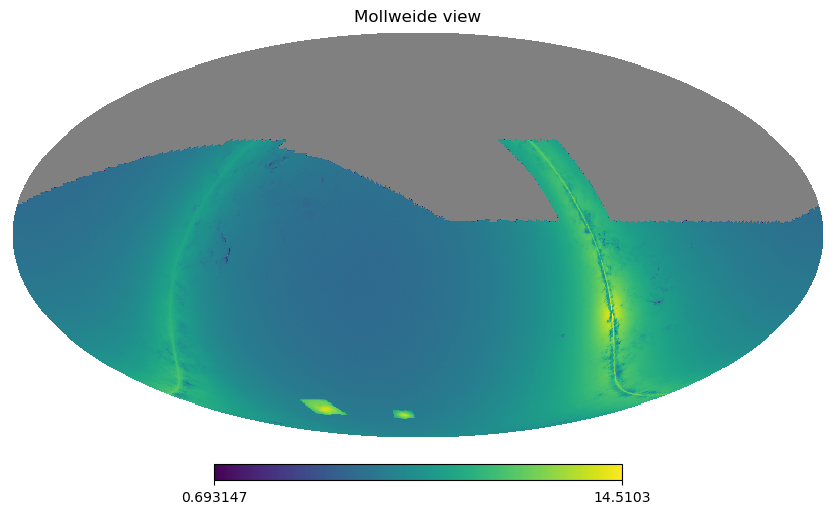

In [12]:
%%time
import lsdb

trilFn = "/mnt/beegfs/scratch/data/TRILEGAL_hipscat/TRILEGAL/"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec'])
h = tril.skymap(lambda df, a: np.log(len(df)+1), order=9)
print("Total rows:", tril.hc_structure.catalog_info.total_rows)

### 3) Import into a HiPSCat catalog (with variable pixel sizes, roughly constant number of sources per pixel)

In [15]:

try:
    client.shutdown()
    client.close()

except Exception as e: 
    print("Exception raised", e)

In [16]:
%%time

in_file_paths = glob.glob("/mnt/beegfs/scratch/data/TRILEGAL_parquet/TRILEGAL-*.parquet")
print(f"Input files: {len(in_file_paths)}")
in_file_paths.sort()
args = ImportArguments(
    output_artifact_name="TRILEGAL_level_5",
    output_path="/mnt/beegfs/scratch/data/TRILEGAL_hipscat/",
    input_file_list=in_file_paths,
    file_reader="parquet",
    ra_column="ra",
    dec_column="dec",
    constant_healpix_order=5,  # <====
    catalog_type="object",
    sort_columns="ra",
    dask_n_workers=12,  # <==== was running out of memory with 96, 48, 24
    dask_tmp="/nvme/tmp/dask_tmp",
    tmp_dir="/nvme/tmp/tmp_dir",
    resume=False,
    # pixel_threshold=5_000_000, # <====
    add_hipscat_index=True    
)
runner.pipeline(args)

Input files: 697


Planning  : 100%|█████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.28s/it]
/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35227 instead
  warnings.warn(
Finishing : 100%|█████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


CPU times: user 11min 24s, sys: 5min 9s, total: 16min 33s
Wall time: 56min 30s


In [17]:
%%time

from dask.distributed import Client

try:
    client.shutdown()
    client.close()

except Exception as e: 
    print("Exception raised", e)


mem_frac=1./50
print(mem_frac)
client = Client(n_workers=48, threads_per_worker=1, memory_limit=mem_frac)
 # use fewer cores to increase mem/core
client

0.02


/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37157 instead
  warnings.warn(


CPU times: user 227 ms, sys: 160 ms, total: 387 ms
Wall time: 756 ms


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37157/status,
Dashboard: http://127.0.0.1:37157/status,Workers: 48
Total threads: 48,Total memory: 1.42 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44669,Workers: 48
Dashboard: http://127.0.0.1:37157/status,Total threads: 48
Started: Just now,Total memory: 1.42 TiB
Comm: tcp://127.0.0.1:38161,Total threads: 1
Dashboard: http://127.0.0.1:34851/status,Memory: 30.23 GiB
Nanny: tcp://127.0.0.1:33167,


Total rows: 11433322690


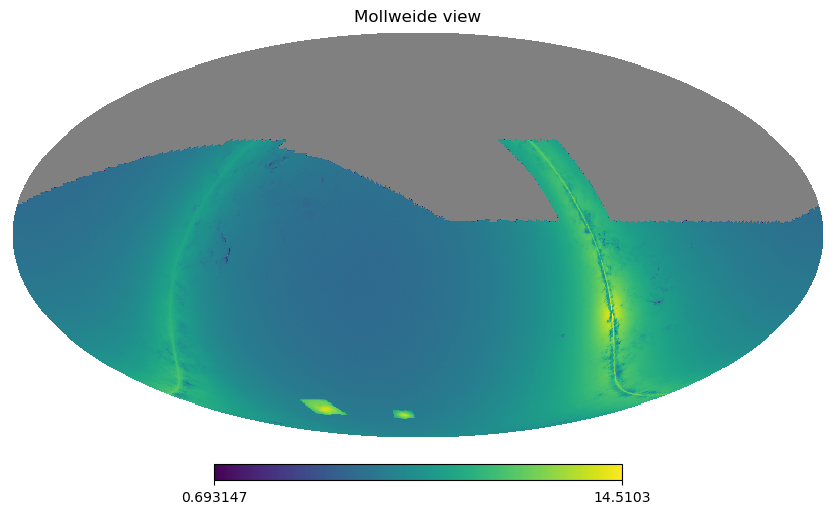

In [18]:
import lsdb

trilFn = "/mnt/beegfs/scratch/data/TRILEGAL_hipscat/TRILEGAL_level_5/"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec'])
h = tril.skymap(lambda df, a: np.log(len(df)+1), order=9)
print("Total rows:", tril.hc_structure.catalog_info.total_rows)

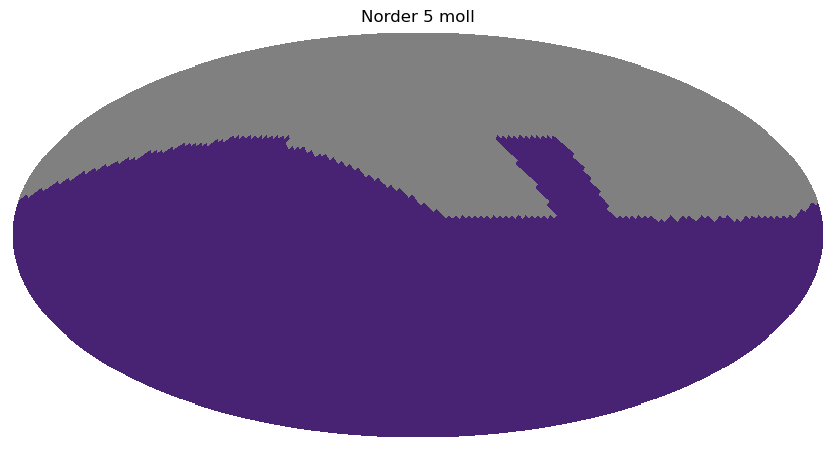

In [19]:
tril.plot_pixels('moll')

### 4) Import into a HiPSCat catalog (with variable pixel sizes, roughly constant number of sources per pixel)

In [ ]:
%%time

import hipscat_import.pipeline as runner
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.catalog.file_readers import ParquetReader

in_file_paths = glob.glob("/mnt/beegfs/scratch/data/TRILEGAL_parquet/TRILEGAL-*.parquet")
print(f"Input files: {len(in_file_paths)}")
in_file_paths.sort()
args = ImportArguments(
    output_artifact_name="TRILEGAL_level_6",
    output_path="/mnt/beegfs/scratch/data/TRILEGAL_hipscat/",
    input_file_list=in_file_paths,
    file_reader="parquet",
    ra_column="ra",
    dec_column="dec",
    constant_healpix_order=12,  # <====
    catalog_type="object",
    sort_columns="ra",
    dask_n_workers=20,
    dask_tmp="/nvme/tmp/dask_tmp",
    tmp_dir="/nvme/tmp/tmp_dir",
    resume=False,
    # pixel_threshold=5_000_000, # <====
    add_hipscat_index=True    
)
runner.pipeline(args)

/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input files: 697


Binning   :   0%|                                                                 | 0/2 [00:00<?, ?it/s]

/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 13.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Total rows: 11433322690
CPU times: user 3min 45s, sys: 3min 16s, total: 7min 1s
Wall time: 4min 40s


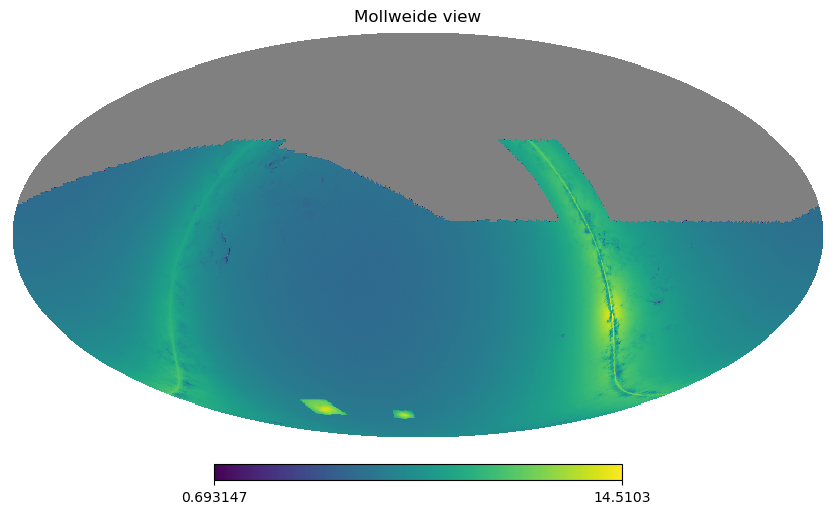

In [27]:
%%time

trilFn = "/mnt/beegfs/scratch/data/TRILEGAL_hipscat/TRILEGAL_level_6/"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec'])
h = tril.skymap(lambda df, a: np.log(len(df)+1), order=6)
print("Total rows:", tril.hc_structure.catalog_info.total_rows)

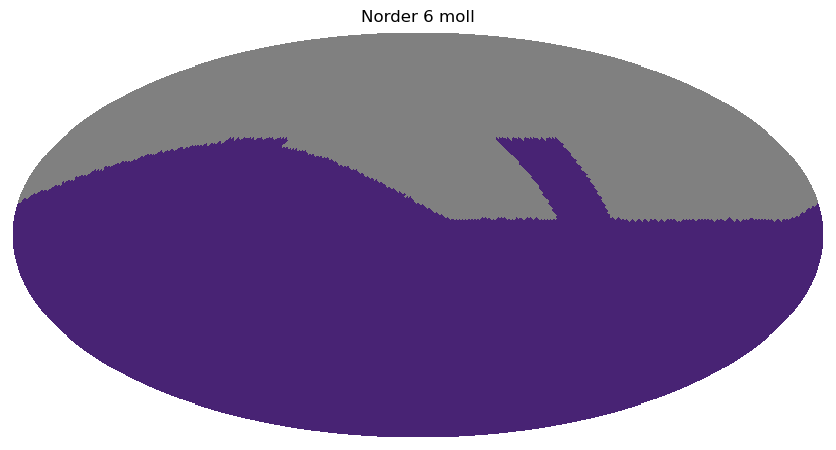

In [30]:
tril.plot_pixels('moll')

In [ ]:
lsdb.plot_pixels('moll')